# **Семинар 12.** Автоэнкодер

In [1]:
import glob
import os
from typing import Union

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

from lightning import LightningModule, Trainer

from sklearn.model_selection import train_test_split

In [2]:
# !kaggle datasets download -p data/ --unzip jessicali9530/lfw-dataset

In [3]:
!ls data/

lfw_allnames.csv    matchpairsDevTest.csv      pairs.csv
lfw_attributes.txt  matchpairsDevTrain.csv     people.csv
lfw-deepfunneled    mismatchpairsDevTest.csv   peopleDevTest.csv
lfw_readme.csv	    mismatchpairsDevTrain.csv  peopleDevTrain.csv


In [ ]:
!ls data/lfw-deepfunneled/lfw-deepfunneled/

In [5]:
def imshow(image: Union[np.ndarray, torch.Tensor]) -> None:
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy(force=True)
    
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [6]:
metadata = pd.read_csv("data/lfw_attributes.txt", sep="\t", skiprows=1)
print(f"{metadata.shape = }")
metadata.head()

metadata.shape = (13143, 75)


,person,imagenum,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,Aaron Eckhart,1,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.195580,-0.835609,-0.351468,...,0.361738,1.166118,-1.164916,-1.139990,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,Aaron Guiel,1,0.169851,-0.982408,0.422709,-1.282184,-1.360060,-0.867002,-0.452293,-0.197521,...,-0.832036,-0.397680,0.874160,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.666760,-0.496559
2,Aaron Patterson,1,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,Aaron Peirsol,1,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,Aaron Peirsol,2,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.082680,-0.439614,-0.359859,-0.760774,-0.410152


In [7]:
image_filepaths = sorted(glob.glob("data/lfw-deepfunneled/lfw-deepfunneled/*/*.jpg"))
image_filepaths = pd.DataFrame({"filepath": image_filepaths})

image_filepaths[["person", "imagenum"]] = (
    image_filepaths["filepath"]
    .map(lambda filepath: os.path.basename(os.path.splitext(filepath)[0]))
    .str.rsplit("_", n=1, expand=True)
)

image_filepaths["person"] = image_filepaths["person"].str.replace("_", " ")
image_filepaths["imagenum"] = image_filepaths["imagenum"].astype(int)

print(f"{image_filepaths.shape = }")
image_filepaths.head()

image_filepaths.shape = (13233, 3)


,filepath,person,imagenum
0,data/lfw-deepfunneled/lfw-deepfunneled/AJ_Cook...,AJ Cook,1
1,data/lfw-deepfunneled/lfw-deepfunneled/AJ_Lama...,AJ Lamas,1
2,data/lfw-deepfunneled/lfw-deepfunneled/Aaron_E...,Aaron Eckhart,1
3,data/lfw-deepfunneled/lfw-deepfunneled/Aaron_G...,Aaron Guiel,1
4,data/lfw-deepfunneled/lfw-deepfunneled/Aaron_P...,Aaron Patterson,1


In [8]:
metadata = metadata.merge(image_filepaths, on=["person", "imagenum"])
print(f"{metadata.shape = }")
# metadata.head()

metadata.shape = (13143, 76)


In [9]:
train_metadata, eval_metadata = train_test_split(metadata, test_size=0.1, random_state=42)
len(train_metadata), len(eval_metadata)

(11828, 1315)

In [10]:
def load_images(metadata: pd.DataFrame) -> torch.Tensor:
    images = []

    for filepath in tqdm(metadata["filepath"], desc="Loading images"):
        image = cv2.cvtColor(cv2.imread(filepath), cv2.COLOR_BGR2RGB)

        height, width, _ = image.shape
        center = height // 2, width // 2
        image = cv2.getRectSubPix(image, (128, 128), center)

        images.append(image / 255)

    return torch.from_numpy(np.stack(images)).permute(0, 3, 1, 2).float()

In [11]:
train_images = load_images(train_metadata)
eval_images = load_images(eval_metadata)

Loading images: 100%|██████████| 1315/1315 [00:00<00:00, 3465.87it/s]


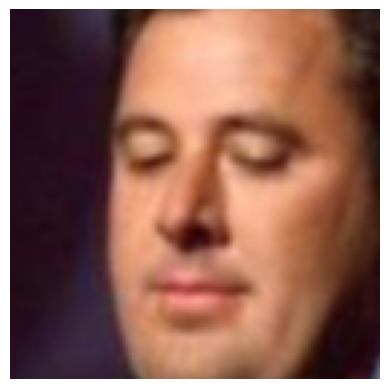

In [12]:
imshow(train_images[42])

In [13]:
class ImageDataset(TensorDataset):
    def __getitem__(self, index: int) -> torch.Tensor:
        return super().__getitem__(index)[0]


train_dataset = ImageDataset(train_images)
eval_dataset = ImageDataset(eval_images)

len(train_dataset), len(eval_dataset)

(11828, 1315)

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=8)
val_dataloader = DataLoader(eval_dataset, batch_size=256, num_workers=8)

for batch in train_dataloader:
    break

batch.shape

torch.Size([256, 3, 128, 128])

In [15]:
class ImageAutoencoder(LightningModule):
    def __init__(self, num_channels: int, latent_dim: int, learning_rate: float = 1e-3) -> None:
        super().__init__()

        self.num_channels = num_channels
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate

        self.encoder = nn.Sequential(
            nn.Conv2d(num_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, latent_dim),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 16 * 16),
            nn.Unflatten(1, (128, 16, 16)),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, num_channels, kernel_size=2, stride=2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.decode(self.encode(x))

    def training_step(self, x: torch.Tensor) -> torch.Tensor:
        x_hat = self(x)

        loss = nn.functional.mse_loss(x_hat, x)
        self.log("train-loss", loss, prog_bar=True)

        return loss

    def validation_step(self, x: torch.Tensor) -> None:
        x_hat = self(x)

        loss = nn.functional.mse_loss(x_hat, x)
        self.log("val-loss", loss, prog_bar=True)

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(x)

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        return self.decoder(z)

In [ ]:
autoencoder = ImageAutoencoder(3, 512, learning_rate=1e-3)

trainer = Trainer(max_epochs=100, log_every_n_steps=10)
trainer.fit(autoencoder, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

In [17]:
autoencoder.eval()

ImageAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=32768, out_features=512, bias=True)
    (14): ReLU()
  )
  (decoder): Sequential(
    (0):

### We can rebuild him. We have the technology

Теперь давайте посмотрим, как обученный автоэнкодер восстанавливает изображения лиц

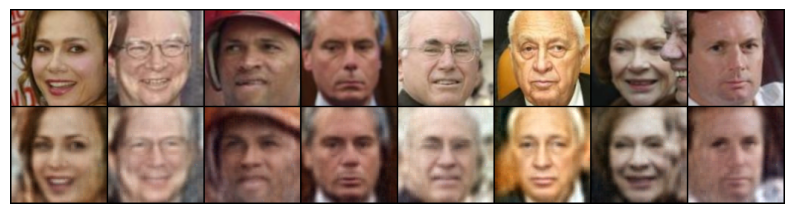

In [18]:
original_images = eval_dataset[42:50]
restored_images = autoencoder(original_images).clip(0, 1)

grid = make_grid(torch.cat((original_images, restored_images)))

plt.figure(figsize=(10, 6))
imshow(grid)

### Choose Your Fighter

Мы также можем создать совершенно новые лица, передав в метод `decode` случайный набор признаков. Однако необходимо учесть, что распределение искусственных признаков должно быть похоже на распределение выходов энкодера

In [19]:
z = []

with torch.no_grad():
    for i in tqdm(range(0, len(train_images), 256)):
        batch = train_images[i:i + 256]
        z.append(autoencoder.encode(batch))

z = torch.cat(z, dim=0)
z.shape

  0%|          | 0/47 [00:00<?, ?it/s]

100%|██████████| 47/47 [00:26<00:00,  1.78it/s]


torch.Size([11828, 512])

In [20]:
z_mean = z.mean(dim=0, keepdims=True)
z_std = z.std(dim=0, keepdims=True)

Для начала посмотрим, как выглядит «средний» человек

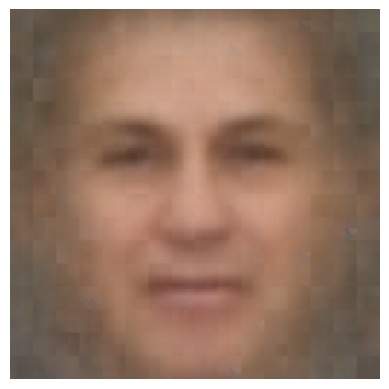

In [21]:
imshow(autoencoder.decode(z_mean).squeeze(0))

Теперь попробуем воспроизвести распределение латентного пространства. Простой вариант — предположить, что все признаки независимы и нормально распределены

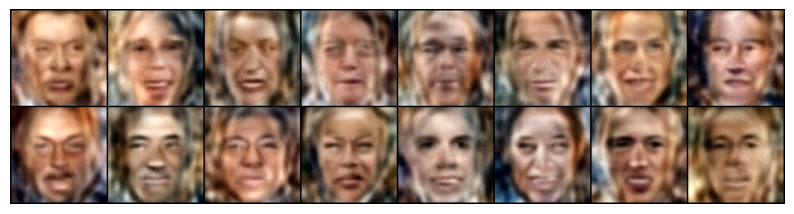

In [22]:
num_samples = 16

synthetic_z = torch.normal(mean=z_mean.expand(num_samples, -1), std=z_std.expand(num_samples, -1))
synthetic_images = autoencoder.decode(synthetic_z).clip(0, 1)

grid = make_grid(synthetic_images)

plt.figure(figsize=(10, 6))
imshow(grid)

Чтобы учесть взаимосвязи между признаками, используем `torch.distributions.MultivariateNormal`

In [23]:
z_centered = z - z_mean

z_cov = (z_centered.T @ z_centered) / z.shape[0] 
z_cov = z_cov + torch.eye(z_cov.shape[0]) * 1e-5

latent_dist = torch.distributions.MultivariateNormal(z_mean.squeeze(0), covariance_matrix=z_cov)

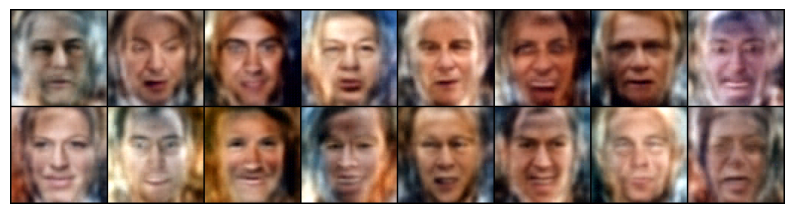

In [24]:
num_samples = 16

synthetic_z = latent_dist.sample((num_samples,))
synthetic_images = autoencoder.decode(synthetic_z).clip(0, 1)

grid = make_grid(synthetic_images)

plt.figure(figsize=(10, 6))
imshow(grid)

### Let's put a smile on that face

Напоследок давайте применим наши знания на благо всего человечества и научимся делать людей счастливыми.

Идея состоит в том, что где-то в латентном пространстве закодировано наличие или отсутствие улыбки. Мы можем пропустить через энкодер несколько фотографий улыбающихся и опечаленных людей и найти разность между соответствующими представлениями — это и будет вектор улыбки.

Далее остается лишь пропустить интересующую нас фотографию через энкодер, добавить к результату вектор улыбки и восстановить изображение с помощью декодера.

In [25]:
ordered_by_smiling = train_metadata["Smiling"].to_numpy().argsort()

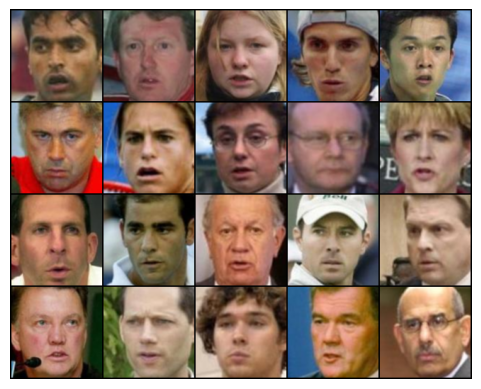

In [26]:
gloom_idx = ordered_by_smiling[:20]
 
gloom_images = train_dataset[gloom_idx]
grid = make_grid(gloom_images, nrow=5)

imshow(grid)

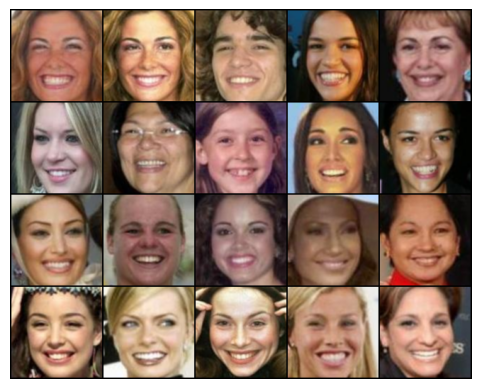

In [27]:
smile_idx = ordered_by_smiling[-20:]

smile_images = train_images[smile_idx]
grid = make_grid(smile_images, nrow=5)

imshow(grid)

In [28]:
smile = z[smile_idx].mean(dim=0, keepdims=True) - z[gloom_idx].mean(dim=0, keepdims=True)
smile.shape

torch.Size([1, 512])

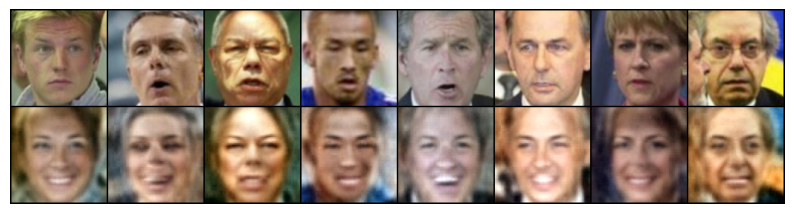

In [29]:
idx = eval_metadata["Smiling"].to_numpy().argsort()[:8]

original_images = eval_dataset[idx]
modified_images = autoencoder.decode(autoencoder.encode(original_images) + smile).clip(0, 1)

grid = make_grid(torch.cat((original_images, modified_images)))

plt.figure(figsize=(10, 6))
imshow(grid)